In [1]:
import pickle
import os
import json
from copy import deepcopy
import pandas as pd
import csv
from datetime import datetime, timedelta
from collections import Counter
import numpy as np

In [5]:
path =os.path.expanduser('~/Documents/Data/NYPData/HF/')

In [65]:
fh = open(path + "EDDC_HF_2012_2018_ouput.json", 'r')
data3 = json.load(fh)

In [68]:
data = deepcopy(data3)

add eligibility

In [67]:
for pid in data3:
    if data3[pid]['age']==-1:
        print(pid,data3[pid]['clientID'])

In [69]:
len(data3)

1993

In [66]:
eligible=[]
c=0
for pid in data3: 
#     print(pid)
#     print(data3[pid]['age'])
    if len(data3[pid]['appt'])>1 and data3[pid]['service']=='MED':
        for date in data3[pid]['appt']:
            age=int(date[0:4])-data3[pid]['age']
            if age>17 and age<90:
                eligible.append(pid)
            if age>2000:
                c=c+1
                
            break
print(len(eligible),c)

1474 0


In [70]:
for pid in data3:
    if pid in eligible:
        pass
    else:
        del data[pid]

In [71]:
clientguid=[]
for pid in data:
    if data[pid]['clientID'] not in clientguid and pid in eligible:
        clientguid.append(data[pid]['clientID'])
print(len(clientguid))

1248


In [72]:
print(len(data))

1474


compute outcome measures for 30, 60, 90 day readmissions

In [73]:
readmission={}
readmissionvisitguids30=[]
readmissionvisitguids60=[]
readmissionvisitguids90=[]
c=0
s=0
r=0
for guid in clientguid:
    readmission[guid]=[]
for guid in clientguid:
    for pid in data:
        if int(guid)==int(data[pid]['clientID']):
            readmission[guid].append([data[pid]['admittime'],data[pid]['dischargetime'],pid])
            r=r+1
print("num unique pt guids",len(readmission))  
print("num visits",len(data))
l=0
a=0
b=0
for guid in readmission:
    if len(readmission[guid])>1:
        l=l+1
for guid in readmission:
    for i in range(len(readmission[guid])-1):
        s=s+1
        if (datetime.strptime(readmission[guid][i+1][0],'%Y-%m-%d %H:%M:%S')-datetime.strptime(readmission[guid][i][1],'%Y-%m-%d %H:%M:%S')).days>=30:
            c=c+1
        else:
            readmissionvisitguids30.append(readmission[guid][i+1][2])
            
        if (datetime.strptime(readmission[guid][i+1][0],'%Y-%m-%d %H:%M:%S')-datetime.strptime(readmission[guid][i][1],'%Y-%m-%d %H:%M:%S')).days<60:
            readmissionvisitguids60.append(readmission[guid][i+1][2])
        if (datetime.strptime(readmission[guid][i+1][0],'%Y-%m-%d %H:%M:%S')-datetime.strptime(readmission[guid][i][1],'%Y-%m-%d %H:%M:%S')).days<90:
            readmissionvisitguids90.append(readmission[guid][i+1][2])
        
readmissionvisitguids30=list(set(readmissionvisitguids30))
print("num unique pt guids with more than 1 admission",l)
print("num readmissions",s)
print("num re-admissions that are NOT 30-day",c)
print("num re-admissions that are 30-day",len(readmissionvisitguids30))
print("num re-admissions that are 60-day",len(readmissionvisitguids60))
print("num re-admissions that are 90-day",len(readmissionvisitguids90))

num unique pt guids 1248
num visits 1474
num unique pt guids with more than 1 admission 177
num readmissions 226
num re-admissions that are NOT 30-day 192
num re-admissions that are 30-day 34
num re-admissions that are 60-day 61
num re-admissions that are 90-day 89


In [74]:
for pid in data:
    data[pid]['30day_readmit']=0
    data[pid]['60day_readmit']=0
    data[pid]['90day_readmit']=0
    data[pid]['LOS']=(datetime.strptime(data[pid]['dischargetime'],'%Y-%m-%d %H:%M:%S') - datetime.strptime(data[pid]['admittime'], '%Y-%m-%d %H:%M:%S')).days
    if pid in readmissionvisitguids30:
        data[pid]['30day_readmit']=1
    if pid in readmissionvisitguids60:
        data[pid]['60day_readmit']=1
    if pid in readmissionvisitguids90:
        data[pid]['90day_readmit']=1

In [75]:
user_quartile=pd.read_excel('/Users/yiyezhang/Dropbox/Grant-and-IRB/AHRQ R03/Analysis/EDDC_order_2012_2018_analysis.xlsx', sheetname='MDOnly_1order_peryear')

/Users/yiyezhang/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [14]:
Q1=[]
for user in user_quartile[user_quartile['Q1']==1]['userguid']:
    Q1.append(user)
Q3=[]
for user in user_quartile[user_quartile['Q4']==1]['userguid']:
    Q3.append(user)

In [15]:
userguid=[]
for pid in data:
    for date in data[pid]['appt']:
        for u in data[pid]['appt'][date]['user']:
            if u not in userguid:
                userguid.append(u)
print(len(userguid))

2490


get list of unique diagnoses

In [76]:
diaglist = list()
for pid in data:
    if len(data[pid]['appt']) != 0:
        for date in sorted(iter(data[pid]['appt'])):
            if 'withinappt' not in data[pid]['appt'][date] or len(data[pid]['appt'][date]['withinappt']) == 0:
                for i in data[pid]['appt'][date]['diag']:
                    diaglist.append(i)
                    # for key, value in i.items():
                    #     diaglist.append(value)
            elif len(data[pid]['appt'][date]['withinappt']) > 0:
                for time in sorted(iter(data[pid]['appt'][date]['withinappt'])):
                    for i in data[pid]['appt'][date]['withinappt'][time]['diag']:
                        for key, value in i.items():
                            diaglist.append(value)

In [77]:
diaglist=list(set(diaglist))

In [78]:
#create VTE outcome
import math
c=Counter(diaglist)
num=0
for i in c:
    if isinstance(i, float)==False:
        if i[0:3]=='I82':
            num=num+c[i]
num

17

In [79]:
orderlist = []
for pid in data:
    if len(data[pid]['appt']) != 0:
        for date in sorted(iter(data[pid]['appt'])):
            if 'withinappt' not in data[pid]['appt'][date] or len(data[pid]['appt'][date]['withinappt']) == 0:
                for icd in range(len(data[pid]['appt'][date]['proc'])):
                    orderlist.append(str(data[pid]['appt'][date]['proc'][icd]))
            elif len(data[pid]['appt'][date]['withinappt']) > 0:
                for time in sorted(iter(data[pid]['appt'][date]['withinappt'])):
                    for p in data[pid]['appt'][date]['withinappt'][time]['proc']:
                        orderlist.append(p)

In [80]:
orderlist=list(set(orderlist))

In [81]:
druglist = []
for pid in data:
    if len(data[pid]['appt']) != 0:
        for date in sorted(iter(data[pid]['appt'])):
            if 'withinappt' not in data[pid]['appt'][date] or len(data[pid]['appt'][date]['withinappt']) == 0:
                for icd in range(len(data[pid]['appt'][date]['drug'])):
                    druglist.append(data[pid]['appt'][date]['drug'][icd])
                    # druglist.append(data[pid]['appt'][date]['drug'][icd]['name'])
            elif len(data[pid]['appt'][date]['withinappt']) > 0:
                for time in sorted(iter(data[pid]['appt'][date]['withinappt'])):
                    for p in data[pid]['appt'][date]['withinappt'][time]['drug']:
                        druglist.append(p['name'])

In [82]:
druglist=list(set(druglist))

In [83]:
len(diaglist)

1539

In [84]:
len(orderlist)

143

In [85]:
len(druglist)

1045

In [86]:
#generate number of diagnosis
diaglistpt={}
for pid in data:
    diaglistpt[pid]=[]
    for date in data[pid]['appt']:
        for icd in data[pid]['appt'][date]['diag']:
            if icd not in diaglistpt[pid] and pd.isna(icd)==False:
                diaglistpt[pid].append(icd)
    #print(pid,len(diaglistpt[pid]))

In [87]:
diag_tf={}
for item in diaglist:
    diag_tf[item]={}
    for pid in data:
        diag_tf[item][pid]=0
        for date in data[pid]['appt']:
            for icd in data[pid]['appt'][date]['diag']:
                if icd==item:
                    diag_tf[item][pid]=1/len(diaglistpt[pid])

In [88]:
diag_df={}
for item in diaglist:
    diag_df[item]=[]
    for pid in data:
        for date in data[pid]['appt']:
            for icd in data[pid]['appt'][date]['diag']:
                if icd==item and pid not in diag_df[item] and pd.isna(icd)==False:
                    diag_df[item].append(pid)

In [89]:
N=len(data)
diag_idf={}
for item in diaglist:
    diag_idf[item]=np.log(N/(len(diag_df[item])+1)) 

In [90]:
diag_td_idf={}
for item in diaglist:
    diag_td_idf[item]={}
    for pid in data:
        diag_td_idf[item][pid]=diag_tf[item][pid]*diag_idf[item]

In [91]:
diag_td_idf_list={}
for item in diag_td_idf:
    diag_td_idf_list[item]=sum(diag_td_idf[item].values())

In [92]:
{k: v for k, v in sorted(diag_td_idf_list.items(), key=lambda item: item[1], reverse=True)}

{'R06.02': 63.994729385577024,
 'I50.23': 60.64729010071898,
 'R07.9': 54.91222305585354,
 'I48.91': 52.84046139966327,
 'I50.33': 49.862338016244195,
 'N17.9': 49.482515491910355,
 'I50.9': 49.151524841766445,
 'I10': 49.09569675748538,
 'R06.00': 47.92032829207493,
 'I25.10': 42.93272333899927,
 'E11.9': 38.04612126238426,
 'J18.9': 37.03987476852903,
 'I50.21': 32.8951053014727,
 'I50.20': 31.590237075242282,
 'D64.9': 31.437761972009312,
 'R60.0': 30.362868326870224,
 'I50.22': 29.943388732418228,
 'I34.0': 29.440161112882784,
 'R09.02': 28.436531649267653,
 'E87.70': 28.364227876542635,
 'I50.30': 28.340109574909356,
 'N18.9': 27.745322776542714,
 'J44.9': 27.01982915823912,
 'R05': 26.446636573638603,
 'J44.1': 26.306663288777695,
 'R10.9': 24.204256030162394,
 'N18.6': 23.75082913429108,
 'M79.89': 23.454339025221074,
 'E78.5': 22.90631406902877,
 'I47.2': 22.6326986813485,
 'R79.89': 22.597309900655745,
 'I50.43': 22.25005072649559,
 'I42.9': 22.234275326666793,
 'I50.1': 21.79

td_idf for orders

In [93]:
#generate number of orders
orderlistpt={}
for pid in data:
    orderlistpt[pid]=[]
    for date in data[pid]['appt']:
        for icd in data[pid]['appt'][date]['proc']:
            if pd.isna(icd)==False:
                orderlistpt[pid].append(icd)
    #print(pid,len(diaglistpt[pid]))

In [94]:
order_tf={}
for item in orderlist:
    order_tf[item]={}
    for pid in data:
        order_tf[item][pid]=0
        for date in data[pid]['appt']:
            for icd in data[pid]['appt'][date]['proc']:
                if icd==item and pd.isna(icd)==False:
                    order_tf[item][pid]=(order_tf[item][pid]+1)/len(orderlistpt[pid])

In [95]:
order_df={}
for item in orderlist:
    order_df[item]=[]
    for pid in data:
        for date in data[pid]['appt']:
            for icd in data[pid]['appt'][date]['proc']:
                if icd==item and pid not in order_df[item] and pd.isna(icd)==False:
                    order_df[item].append(pid)

In [96]:
N=len(data)
order_idf={}
for item in orderlist:
    order_idf[item]=np.log(N/(len(order_df[item])+1)) 

In [97]:
order_td_idf={}
for item in orderlist:
    order_td_idf[item]={}
    for pid in data:
        order_td_idf[item][pid]=order_tf[item][pid]*order_idf[item]

In [98]:
order_td_idf_list={}
for item in order_td_idf:
    order_td_idf_list[item]=sum(order_td_idf[item].values())

In [99]:
{k: v for k, v in sorted(order_td_idf_list.items(), key=lambda item: item[1], reverse=True)}

{'AM Lab Order Set': 29.05117180143333,
 'Commonly Used Orders - AM Draw': 27.5515634556324,
 'MED - ED Admitted Patient Order Set': 27.24809400200672,
 'MED - ED Admitted Patient Order Set (LMH)': 24.37181856754413,
 'ED Order Set - A General Comprehensive Order Set': 22.721908437887375,
 'HIV Testing Order Set': 19.78243856059331,
 'Blood Culture x2': 17.19010101027016,
 'ED Order Set - A General Comprehensive Order Set (LMH)': 16.926491114656102,
 'Urine Lab Order Set': 15.735876356585498,
 'Lab_order': 15.625243979319498,
 'ED Order Set - General (LMH)': 15.311128563808225,
 'ED Order Set -  Abdominal/Flank Pain': 12.88189438686678,
 'Warfarin Order Set': 12.704659077818002,
 'Admit NYP Order Set..': 12.007709092720884,
 'ED Order Set - General': 11.951216832243137,
 'ED Order Set  - A General Comprehensive Order Set (LMH)': 11.946640096954578,
 'Legionella Detection': 11.886321597502265,
 'ED Order set - Dyspnea/CHF/COPD/Asthma': 11.69154048542483,
 'PM Labs Order Set': 11.3903204

td_idf for drugs

In [100]:
druglistpt={}
for pid in data:
    druglistpt[pid]=[]
    for date in data[pid]['appt']:
        for icd in data[pid]['appt'][date]['drug']:
            if pd.isna(icd)==False:
                druglistpt[pid].append(icd)
    #print(pid,len(diaglistpt[pid]))

In [101]:
drug_tf={}
for item in druglist:
    drug_tf[item]={}
    for pid in data:
        drug_tf[item][pid]=0
        for date in data[pid]['appt']:
            for icd in data[pid]['appt'][date]['drug']:
                if icd==item and pd.isna(icd)==False:
                    drug_tf[item][pid]=(drug_tf[item][pid]+1)/len(druglistpt[pid])

In [102]:
drug_df={}
for item in druglist:
    drug_df[item]=[]
    for pid in data:
        for date in data[pid]['appt']:
            for icd in data[pid]['appt'][date]['drug']:
                if icd==item and pid not in drug_df[item] and pd.isna(icd)==False:
                    drug_df[item].append(pid)

In [103]:
N=len(data)
drug_idf={}
for item in druglist:
    drug_idf[item]=np.log(N/(len(drug_df[item])+1))

In [104]:
drug_td_idf={}
for item in druglist:
    drug_td_idf[item]={}
    for pid in data:
        drug_td_idf[item][pid]=drug_tf[item][pid]*drug_idf[item]

In [105]:
drug_td_idf_list={}
for item in drug_td_idf:
    drug_td_idf_list[item]=sum(drug_td_idf[item].values())

In [106]:
{k: v for k, v in sorted(drug_td_idf_list.items(), key=lambda item: item[1], reverse=True)}

{'Furosemide Oral': 13.735128368060332,
 'Pneumococcal 23-Valent Vacc (Pneumovax)': 13.18084857645011,
 'Atorvastatin Tab': 13.129157939867115,
 'Aspirin EC Tab': 12.908973541635955,
 'Lisinopril Oral': 12.786775091649151,
 'Influenza Virus Vaccine Inj >3 Years Old': 12.763334563772844,
 'Carvedilol Tab': 12.761025520082942,
 'Heparin Inj': 12.570051139542509,
 'Aspirin Tab': 11.921297188453165,
 'Metoprolol Tartrate Tab': 11.913996146710536,
 'Metoprolol XL Sustained Release Oral': 11.795263300141482,
 'Albuterol Inh Soln': 11.68021052654512,
 'Insulin Aspart Prandial Scale Pre-Meal': 11.339468611276628,
 'Furosemide Inj': 11.330193484469238,
 'Insulin Aspart Bedtime Scale': 11.275131107086821,
 'Pantoprazole Delayed Release Tab': 11.268871569112875,
 'Senna Oral': 11.251789837698507,
 'Acetaminophen Tab': 11.232592984277895,
 'Docusate Sodium Cap': 11.207459420883275,
 'Glucagon Inj': 11.14801387537323,
 'Glucose Gel Oral': 11.140929190999831,
 'Ipratropium Bromide Inh Soln': 10.9468

In [107]:
import matplotlib.pylab as plt

lists = sorted(drug_td_idf_list.items(), key=lambda item: item[1],reverse=True)
x, y = zip(*lists) # unpack a list of pairs into two tuples
numBins = 10
plt.hist(y,numBins, density=True, cumulative=1)
plt.show()

<Figure size 640x480 with 1 Axes>

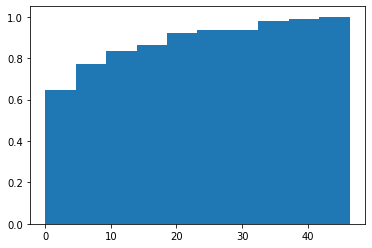

In [150]:
import matplotlib.pylab as plt

lists = sorted(order_td_idf_list.items(), key=lambda item: item[1])
x, y = zip(*lists) # unpack a list of pairs into two tuples
numBins = 10
plt.hist(y,numBins, density=True, cumulative=True)
plt.show()

In [108]:
drug_td_idf_df=pd.DataFrame.from_dict(drug_td_idf, orient='index')
drug_td_idf_df=drug_td_idf_df.T

In [109]:
order_td_idf_df=pd.DataFrame.from_dict(order_td_idf, orient='index')
order_td_idf_df=order_td_idf_df.T

In [110]:
result = pd.concat([order_td_idf_df, drug_td_idf_df], axis=1, join='inner')

In [123]:
from sklearn import cluster
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
mat = result.values
# Using sklearn
km = cluster.KMeans(n_clusters=6,random_state=3425)
km.fit(mat)
# Get cluster assignment labels
labels = km.labels_
# Format results as a DataFrame
results = pd.DataFrame([result.index,labels]).T

In [127]:
MiniBatchKMeans(n_clusters=6, init_size=1024, batch_size=2048,random_state=20).fit(result)
results.groupby([1]).count()

,0
1,
0,263
1,1056
2,100
3,3
4,1
5,51


Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters


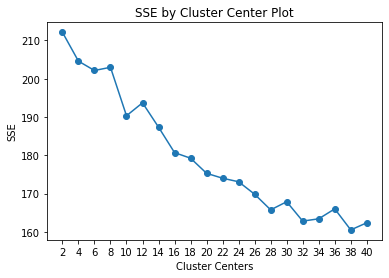

In [115]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048,random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(result, 40)

In [119]:
clusters = MiniBatchKMeans(n_clusters=14, init_size=1024, batch_size=2048, random_state=20).fit_predict(result)

In [226]:
results.to_csv(path+"tfidf_kmeans10.csv", index=False)

get diagnoses, orders, and drugs observed by 90%+ of the patients

In [32]:
N=len(data)

In [34]:
diagNotusedbyall=[]
for item in diaglist:
    used=0
    for pid in data:
        for date in data[pid]['appt']:
            for i in data[pid]['appt'][date]['diag']:
                if i==item:
                    used+=1
    
    if used>N*0.9 : #used by more than 90% of patients
        diagNotusedbyall.append(item)       

In [35]:
orderNotusedbyall=[]
for item in orderlist:
    used=0
    for pid in data:
        for date in data[pid]['appt']:
            for i in data[pid]['appt'][date]['proc']:
                if i==item:
                    used+=1
    
    if used>N*0.9 : #used by more than 90% 
        orderNotusedbyall.append(item)       

In [36]:
len(orderNotusedbyall)

6

In [28]:
orderNotusedbyall

['CTS AM Labs Order Set',
 'Lab_order',
 'AM Lab Order Set',
 'Heparin  Drip Order Set (Adult)',
 'Commonly Used Orders - AM Draw',
 'Warfarin Order Set']

In [37]:
drugNotusedbyall=[]
for item in druglist:
    used=0
    for pid in data:
        for date in data[pid]['appt']:
            for i in data[pid]['appt'][date]['drug']:
                if i==item:
                    used+=1
    
    if used>N*0.9 :
        drugNotusedbyall.append(item)       

In [38]:
len(drugNotusedbyall)

13

In [39]:
for pid in data:
    for date in sorted(iter(data[pid]['appt'])):
        data[pid]['appt'][date]['type'] = 'I'

In [40]:
data2 = deepcopy(data)

re-labeling orders

In [41]:
for pid in data:
    for date in sorted(data[pid]['appt']):
        data2[pid]['appt'][date]['diag'] = []
        data2[pid]['appt'][date]['proc'] = []
        data2[pid]['appt'][date]['drugclass'] = []
        data2[pid]['appt'][date]['user']=[]
#         for icd in range(len(data[pid]['appt'][date]['diag'])):
#             if data[pid]['appt'][date]['diag'][icd] in diagNotusedbyall and data[pid]['appt'][date]['diag'][icd] not in data2[pid]['appt'][date]['diag']: #ADD ONLY DIAGNOSIS THAT WE WANT
#                 data2[pid]['appt'][date]['diag'].append(data[pid]['appt'][date]['diag'][icd])

        for icd in range(len(data[pid]['appt'][date]['proc'])):
            if data[pid]['appt'][date]['proc'][icd] in orderNotusedbyall and data[pid]['appt'][date]['proc'][icd] not in data2[pid]['appt'][date]['proc']:
                if data[pid]['appt'][date]['proc'][icd]=='AM Lab Order Set' or data[pid]['appt'][date]['proc'][icd]=='CTS AM Labs Order Set':
                    data2[pid]['appt'][date]['proc'].append('Commonly Used Orders - AM Draw')
                elif data[pid]['appt'][date]['proc'][icd]=='Lab_order':
                    pass
                else:
                    data2[pid]['appt'][date]['proc'].append(str(data[pid]['appt'][date]['proc'][icd]))
                data2[pid]['appt'][date]['proc']=list(set(data2[pid]['appt'][date]['proc']))
#             if data[pid]['appt'][date]['proc'][icd]== 'Clinical Pathway - Heart Failure Order Set':
#                 data2[pid]['appt'][date]['proc'].append(str(data[pid]['appt'][date]['proc'][icd]))
#             if data[pid]['appt'][date]['proc'][icd]==  'Clinical Pathway - Heart Failure Order Set (LMH)':
#                 data2[pid]['appt'][date]['proc'].append('Clinical Pathway - Heart Failure Order Set')
                
#             if data[pid]['appt'][date]['proc'][icd]==  'ED Order set - Dyspnea/CHF/COPD/Asthma':
#                 data2[pid]['appt'][date]['proc'].append(str(data[pid]['appt'][date]['proc'][icd]))
#             if data[pid]['appt'][date]['proc'][icd]==   'ED Order set - Dyspnea/CHF/COPD/Asthma (LMH)':
#                 data2[pid]['appt'][date]['proc'].append('ED Order set - Dyspnea/CHF/COPD/Asthma')

        for icd in range(len(data[pid]['appt'][date]['drug'])):
            if str(data[pid]['appt'][date]['drug'][icd]) in drugNotusedbyall and data[pid]['appt'][date]['drug'][icd] not in data2[pid]['appt'][date]['drugclass']:
                if str(data[pid]['appt'][date]['drug'][icd])== 'Furosemide Inj' or str(data[pid]['appt'][date]['drug'][icd])== 'Furosemide Oral':
                    data2[pid]['appt'][date]['drug'].append('Furosemide')
                    
                elif str(data[pid]['appt'][date]['drug'][icd])==  'Insulin Aspart Prandial Scale Pre-Meal' or str(data[pid]['appt'][date]['drug'][icd])==  'Insulin Aspart Bedtime Scale':
                    data2[pid]['appt'][date]['drug'].append('Insulin Aspart')
                elif str(data[pid]['appt'][date]['drug'][icd])==  'Potassium Chloride Inj' or str(data[pid]['appt'][date]['drug'][icd])==  'Potassium Chloride Oral':
                    data2[pid]['appt'][date]['drug'].append('Potassium Chloride') 
                else:
                    data2[pid]['appt'][date]['drug'].append(str(data[pid]['appt'][date]['drug'][icd]))
                data2[pid]['appt'][date]['drug']=list(set(data2[pid]['appt'][date]['drug']))

        for u in data[pid]['appt'][date]['user']:
            if u in Q1 and 'Q1' not in data2[pid]['appt'][date]['user']:
                data2[pid]['appt'][date]['user'].append('Q1')
            if u in Q3 and 'Q3' not in data2[pid]['appt'][date]['user']:
                data2[pid]['appt'][date]['user'].append('Q3')

In [42]:
len(data2)

1288

In [77]:
#JSON_FILE = os.path.expanduser(path+"HF_data_filtered_OS.json")

# with open(JSON_FILE, 'w') as outfile:
#     json.dump(data2, outfile, indent=2, sort_keys=True, separators=(',', ': '))


In [78]:
# pickle_out = open(path + 'HF_data_filtered_OS.pickle', 'wb')
# pickle.dump(data2, pickle_out)
# pickle_out.close()

#get number of users for patients who appeared in data2, if patient is seen by >1 user, remove. Else, categorize patient as treated by high/low users

In [43]:
piduser={}
for pid in data2:
    piduser[pid]=[]
    for date in data2[pid]['appt']:
        for i in data2[pid]['appt'][date]['user']:
            piduser[pid].append(i)
    if len(piduser[pid])>0:
        piduser[pid]=list(set(piduser[pid]))

In [45]:
piduser2=deepcopy(piduser)
for pid in piduser:
    if len(piduser[pid])==1:
        pass
    else:
        del piduser2[pid]
print(len(piduser2))

519


In [46]:
data_1Q = deepcopy(data2)
for pid in data2:
    if pid in piduser2:
        if piduser2[pid]==['Q1']:
            pass
        else:
            del data_1Q[pid]
    else:
        del data_1Q[pid]

In [47]:
data_3Q = deepcopy(data2)
for pid in data2:
    if pid in piduser2:
        if piduser2[pid]==['Q3']:
            pass
        else:
            del data_3Q[pid]
    else:
        del data_3Q[pid]

In [48]:
print(len(data_1Q),len(data_3Q))

189 330


In [49]:
#only have HF as diagnosis, got from getSourceData.ipynb
HFlist=[9001251915900270,9001216906000270,9001121093200270,9001173168800270,9001211775200270,9001246400900270,9001220441100270,9001174426900270,9001247254900270,9001109270200270,9001176608700270,9001241780400270,9001234306600270,9001206891600270,9001179229100270,9001265609400270,9001148298400270,9001282931300270,9001246979700270,9001236154600270,9001232695300270,9001283883400270,9001225771000270,9001180467800270,9001235742900270,9001140573400270,9001262036300270,9001277843700270,9001191425900270,9001170806400270,9001143998000270,9001115258800270,9001251701600270,9001189761100270,9001172050300270,9001213409300270,9001174120900270,9001269084300270,9001192844000270,9001187189200270,9001127051300270,9001145898800270,9001241929400270,9001157423500270,9001281548600270,9001277336200270,9001153999000270,9001124832900270,9001103203000270,9001197850700270,9001122106400270,9001183064500270,9001229215400270,9001190326000270,9001283307400270,9001247873000270,9001271734400270,9001137168300270,9001176846300270,9001219793500270,9001205152300270,9001224174300270,9001180232100270,9001162665900270,9001280700600270,9001122902200270,9001283296000270,9001231182100270,9001175917800270,9001118690900270,9001198997800270,9001199107500270,9001257904300270,9001241691500270,9001217549800270,9001133189700270,9001130637700270,9001139094600270,9001134950300270,9001135748000270,9001208316600270,9001139543800270,9001164070700270,9001250210700270,9001161881700270,9001183117300270,9001169276400270,9001188841900270,9001170830800270,9001175772200270,9001175857400270,9001239669600270,9001173008500270,9001176464400270,9001179229900270,9001134997500270,9001213095600270,9001212260100270,9001190777500270,9001261274500270,9001192647900270,9001221808200270,9001204705400270,9001212284600270,9001213056600270,9001226275500270,9001236382900270,9001238991200270,9001234738100270,9001240443800270,9001282946900270,9001260567600270,9001171950100270,9001185043000270,9001256154500270,9001272344700270,9001217202600270,9001273899200270,9001209675100270,9001231430000270,9001124571900270,9001161193900270,9001284903800270,9001144030000270,9001127460400270,9001284311200270,9001142706400270,9001152684100270,9001146841500270]

In [50]:
s=0
l=0
for pid in data2:
#     if int(pid) in HFlist:
        s=s+data2[pid]['90day_readmit']
        l=l+data2[pid]['LOS']
print(s,l/len(data2))

91 11.652950310559007


compare readmission outcome and LOS across patients treated by high/low users

In [51]:
s=0
l=0
for pid in data_1Q:
#     if int(pid) in HFlist:
        s=s+data_1Q[pid]['90day_readmit']
        l=l+data_1Q[pid]['LOS']
print(s,l/len(data_1Q))

18 9.063492063492063


In [52]:
s=0
l=0
for pid in data_3Q:
#     if int(pid) in HFlist:
        s=s+data_3Q[pid]['90day_readmit']
        l=l+data_3Q[pid]['LOS']
print(s,l/len(data_3Q))

26 6.666666666666667


In [409]:
#all orders for EDDC_18_89, for Disco
with open(path+'orders_EDDC_18_89_2012_2018.csv', 'w') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    combined_row = []
    combined_row.append('pid')
    combined_row.append('date')
    combined_row.append('activity')
    combined_row.append('user')
    writer.writerow(combined_row)
    for pid in data2:
#         if int(pid) in HFlist:
                for date in data2[pid]['appt']:
                    if len(data2[pid]['appt'][date]['proc'])>0 or len(data2[pid]['appt'][date]['drug'])>0:
                        combined_row = []
                        combined_row.append(pid)
                        #combined_row.append('@')
                        combined_row.append(date)
                        #combined_row.append('@')
                        combined_row.append(str(sorted(data2[pid]['appt'][date]['proc']))+str(sorted(data2[pid]['appt'][date]['drug'])))
                        combined_row.append(data2[pid]['appt'][date]['user'])
                        writer.writerow(combined_row)

In [104]:
#only patients treated by low users, for Disco, change Q1 to Q3 for high users
with open('Q1_orders_EDDC_HFonly_18_89.csv', 'w') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    combined_row = []
    combined_row.append('pid')
    combined_row.append('date')
    combined_row.append('activity')
    combined_row.append('user')
    writer.writerow(combined_row)
    for pid in data2:
        if int(pid) in HFlist and pid in piduser2:
            if piduser2[pid]==['Q1']:
                for date in data2[pid]['appt']:
                    if len(data2[pid]['appt'][date]['proc'])>0 or len(data2[pid]['appt'][date]['drug'])>0:
                        combined_row = []
                        combined_row.append(pid)
                        #combined_row.append('@')
                        combined_row.append(date)
                        #combined_row.append('@')
                        combined_row.append(str(sorted(data2[pid]['appt'][date]['proc']))+str(sorted(data2[pid]['appt'][date]['drug'])))
                        combined_row.append(data2[pid]['appt'][date]['user'])
                        writer.writerow(combined_row)
                

In [114]:
#SPADE on all orders for EDDC_18_89
with open(path+'SPADE_orders_EDDC_HFonly_18_89.csv', 'w') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    writer.writerow(combined_row)
    for pid in data2:
        if int(pid) in HFlist:
            n=0
            for date in data2[pid]['appt']:
                if len(data2[pid]['appt'][date]['proc'])>0 or len(data2[pid]['appt'][date]['drug'])>0:
                    n=n+1
                    combined_row = []
                    combined_row.append(pid)
                    #combined_row.append('@')
                    combined_row.append(n)
                    #combined_row.append('@')
                    combined_row.append('1')
                    combined_row.append(str(sorted(data2[pid]['appt'][date]['proc']))+str(sorted(data2[pid]['appt'][date]['drug'])))
                    writer.writerow(combined_row)

In [54]:
#optional, subgroup for patients with HF diagnosis only
data_18_89_HFonly_EDDC = deepcopy(data2)
for pid in data2:
    if int(pid) in HFlist:
        pass
    else:
        del data_18_89_HFonly_EDDC[pid]

In [55]:
len(data_18_89_HFonly_EDDC)

67

In [597]:
pickle_out = open(path + 'data_18_89_EDDC_2012_2018.pickle', 'wb')
pickle.dump(data, pickle_out)
pickle_out.close()


In [ ]:
for pid in data2:
    print(pid,data2[pid]['30day_readmit'],data2[pid]['60day_readmit'],data2[pid]['90day_readmit'],data2[pid]['LOS'],data2[pid]['dischargedisposition'])

In [58]:
cluster=pd.read_excel('/Users/yiyezhang/Dropbox/Grant-and-IRB/AHRQ R03/Analysis/EDDC_order_2012_2018_cluster.xlsx', sheetname='EDDC_order_2012_2018_cluster')

generate cluster-specific data for Disco, once you run LCS_clustering.R

In [650]:
#data2: filtered
#data: all
with open(path+'C1_orders_EDDC_HFonly_18_89_6clusters_all.csv', 'w') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    combined_row = []
    combined_row.append('pid')
    combined_row.append('date')
    combined_row.append('activity')
    combined_row.append('user')
    writer.writerow(combined_row)
    for pid in data:
        if  int(pid) in cluster['clientvisitguid'].values:
#             print(pid,cluster.loc[cluster['clientvisitguid']==int(pid)][['cluster']].values[0])
            if cluster.loc[cluster['clientvisitguid']==int(pid)][['cluster6']].values[0]==1:
                for date in data[pid]['appt']:
                    if len(data[pid]['appt'][date]['proc'])>0 or len(data[pid]['appt'][date]['drug'])>0:
                        combined_row = []
                        combined_row.append(pid)
                        #combined_row.append('@')
                        combined_row.append(date)
                        #combined_row.append('@')
                        combined_row.append(str(sorted(data[pid]['appt'][date]['proc']))+str(sorted(data[pid]['appt'][date]['drug'])))
                        combined_row.append(data[pid]['appt'][date]['user'])
                        writer.writerow(combined_row)
                

In [ ]:
#can skip
for pid in data2:
    os=0
    for date in data2[pid]['appt']:
        if  'Clinical Pathway - Heart Failure Order Set (LMH)' in data2[pid]['appt'][date]['proc'] or 'Clinical Pathway - Heart Failure Order Set' in data2[pid]['appt'][date]['proc'] or  'ED Order set - Dyspnea/CHF/COPD/Asthma (LMH)' in data2[pid]['appt'][date]['proc'] or  'ED Order set - Dyspnea/CHF/COPD/Asthma' in data2[pid]['appt'][date]['proc']:
            os=1
            break
    print(pid,os)  

In [61]:
#common drugs in cluster 2
diaglistC2=[]
for pid in data:
    if  int(pid) in cluster['clientvisitguid'].values:
        if cluster.loc[cluster['clientvisitguid']==int(pid)][['cluster6']].values[0]==2:
            for date in data[pid]['appt']:
                for icd in data[pid]['appt'][date]['diag']:
                    diaglistC2.append(icd)
c=Counter(diaglistC2)
c_most_common = [item for item in c.most_common(20)]

In [62]:
c_most_common

[('I50.9', 183),
 ('N17.9', 107),
 ('I48.91', 95),
 ('I10', 89),
 ('D64.9', 72),
 ('R06.02', 71),
 ('I50.23', 69),
 ('I50.33', 68),
 ('J18.9', 53),
 ('E11.9', 46),
 ('I50.21', 42),
 ('I25.10', 42),
 ('R07.9', 38),
 ('R09.02', 37),
 ('A41.9', 34),
 ('R53.1', 34),
 ('R06.00', 33),
 ('E87.1', 32),
 ('I50.30', 32),
 ('R41.82', 32)]

In [63]:
orderlistC3=[]
for pid in data2:
    if  int(pid) in cluster['clientvisitguid'].values:
        if cluster.loc[cluster['clientvisitguid']==int(pid)][['cluster']].values[0]==3:
            for date in data2[pid]['appt']:
                for icd in data2[pid]['appt'][date]['proc']:
                    orderlistC3.append(icd)
c=Counter(orderlistC3)
c_most_common = [item for item in c.most_common(20)]

In [64]:
c_most_common

[('Commonly Used Orders - AM Draw', 4054),
 ('Heparin  Drip Order Set (Adult)', 875),
 ('Warfarin Order Set', 566)]

In [65]:
druglistC3=[]
for pid in data2:
    if  int(pid) in cluster['clientvisitguid'].values:
        if cluster.loc[cluster['clientvisitguid']==int(pid)][['cluster']].values[0]==3:
            for date in data2[pid]['appt']:
                for icd in data2[pid]['appt'][date]['drug']:
                    druglistC3.append(icd)
c=Counter(druglistC3)
c_most_common = [item for item in c.most_common(20)]

In [66]:
c_most_common

[('Potassium Chloride', 1662),
 ('Magnesium Sulfate Inj', 1412),
 ('Warfarin Sodium Oral', 1374),
 ('Potassium Chloride Oral', 1121),
 ('Heparin Drip', 1097),
 ('Furosemide', 1093),
 ('Bumetanide Inj', 994),
 ('Magnesium Oxide Oral', 946),
 ('Furosemide Inj', 919),
 ('Potassium Chloride Inj', 644),
 ('HYDROmorphone Inj', 551),
 ('Potassium Chloride Oral Liq', 353),
 ('Insulin Aspart', 343),
 ('Insulin Aspart Prandial Scale Pre-Meal', 335),
 ('Calcium Gluconate Inj', 301),
 ('Metolazone Oral', 294),
 ('Insulin Aspart Bedtime Scale', 282),
 ('Bumetanide DRIP', 276),
 ('Acetaminophen Tab', 272),
 ('Metoprolol Tartrate Tab', 269)]

In [68]:
print(len(orderlist),len(orderNotusedbyall))
print(len(druglist),len(drugNotusedbyall))
print(len(diaglist),len(diagNotusedbyall))

161 6
1114 13
1492 1


below are list for CCW: https://www2.ccwdata.org/web/guest/condition-categories, ask Yufang for code

In [602]:
obesity=['DXE66.01'	,
'E66.09'	,
'E66.1'	,
'E66.2'	,
'E66.8'	,
'E66.9'	,
'Z68.30'	,
'Z68.31'	,
'Z68.32'	,
'Z68.33'	,
'Z68.34'	,
'Z68.35'	,
'Z68.36'	,
'Z68.37'	,
'Z68.38'	,
'Z68.39'	,
'Z68.41'	,
'Z68.42'	,
'Z68.43'	,
'Z68.44'	,
'Z68.45'	,]

In [604]:
depression=['DXF31.30'	,
'F31.31'	,
'F31.32'	,
'F31.4'	,
'F31.5'	,
'F31.60'	,
'F31.61'	,
'F31.62'	,
'F31.63'	,
'F31.64'	,
'F31.75'	,
'F31.76'	,
'F31.77'	,
'F31.78'	,
'F31.81'	,
'F32.0'	,
'F32.1'	,
'F32.2'	,
'F32.3'	,
'F32.4'	,
'F32.5'	,
'F32.9'	,
'F33.0'	,
'F33.1'	,
'F33.2'	,
'F33.3'	,
'F33.40'	,
'F33.41'	,
'F33.42'	,
'F33.8'	,
'F33.9'	,
'F34.1'	,
'F43.21'	,
'F43.23'	]

In [606]:
HTN=['DXH35.031'	,
'H35.032'	,
'H35.033'	,
'H35.039'	,
'I10'	,
'I11.0'	,
'I11.9'	,
'I12.0'	,
'I12.9'	,
'I13.0'	,
'I13.10'	,
'I13.11'	,
'I13.2'	,
'I15.0'	,
'I15.1'	,
'I15.2'	,
'I15.8'	,
'I15.9'	,
'I67.4'	,
'N26.2']

In [608]:
DM=['DXE08.00'	,
'E08.01'	,
'E08.10'	,
'E08.11'	,
'E08.21'	,
'E08.22'	,
'E08.29'	,
'E08.311'	,
'E08.319'	,
'E08.321'	,
'E08.3211'	,
'E08.3212'	,
'E08.3213'	,
'E08.3219'	,
'E08.329'	,
'E08.3291'	,
'E08.3292'	,
'E08.3293'	,
'E08.3299'	,
'E08.331'	,
'E08.3311'	,
'E08.3312'	,
'E08.3313'	,
'E08.3319'	,
'E08.339'	,
'E08.3391'	,
'E08.3392'	,
'E08.3393'	,
'E08.3399'	,
'E08.341'	,
'E08.3411'	,
'E08.3412'	,
'E08.3413'	,
'E08.3419'	,
'E08.349'	,
'E08.3491'	,
'E08.3492'	,
'E08.3493'	,
'E08.3499'	,
'E08.351'	,
'E08.3511'	,
'E08.3512'	,
'E08.3513'	,
'E08.3519'	,
'E08.3521'	,
'E08.3522'	,
'E08.3523'	,
'E08.3529'	,
'E08.3531'	,
'E08.3532'	,
'E08.3533'	,
'E08.3539'	,
'E08.3541'	,
'E08.3542'	,
'E08.3543'	,
'E08.3549'	,
'E08.3551'	,
'E08.3552'	,
'E08.3553'	,
'E08.3559'	,
'E08.359'	,
'E08.3591'	,
'E08.3592'	,
'E08.3593'	,
'E08.3599'	,
'E08.36'	,
'E08.37X1'	,
'E08.37X2'	,
'E08.37X3'	,
'E08.37X9'	,
'E08.39'	,
'E08.40'	,
'E08.41'	,
'E08.42'	,
'E08.43'	,
'E08.44'	,
'E08.49'	,
'E08.51'	,
'E08.52'	,
'E08.59'	,
'E08.610'	,
'E08.618'	,
'E08.620'	,
'E08.621'	,
'E08.622'	,
'E08.628'	,
'E08.630'	,
'E08.638'	,
'E08.641'	,
'E08.649'	,
'E08.65'	,
'E08.69'	,
'E08.8'	,
'E08.9'	,
'E09.00'	,
'E09.01'	,
'E09.10'	,
'E09.11'	,
'E09.21'	,
'E09.22'	,
'E09.29'	,
'E09.311'	,
'E09.319'	,
'E09.321'	,
'E09.3211'	,
'E09.3212'	,
'E09.3213'	,
'E09.3219'	,
'E09.329'	,
'E09.3291'	,
'E09.3292'	,
'E09.3293'	,
'E09.3299'	,
'E09.331'	,
'E09.3311'	,
'E09.3312'	,
'E09.3313'	,
'E09.3319'	,
'E09.339'	,
'E09.3391'	,
'E09.3392'	,
'E09.3393'	,
'E09.3399'	,
'E09.341'	,
'E09.3411'	,
'E09.3412'	,
'E09.3413'	,
'E09.3419'	,
'E09.349'	,
'E09.3491'	,
'E09.3492'	,
'E09.3493'	,
'E09.3499'	,
'E09.351'	,
'E09.3511'	,
'E09.3512'	,
'E09.3513'	,
'E09.3519'	,
'E09.3521'	,
'E09.3522'	,
'E09.3523'	,
'E09.3529'	,
'E09.3531'	,
'E09.3532'	,
'E09.3533'	,
'E09.3539'	,
'E09.3541'	,
'E09.3542'	,
'E09.3543'	,
'E09.3549'	,
'E09.3551'	,
'E09.3552'	,
'E09.3553'	,
'E09.3559'	,
'E09.359'	,
'E09.3591'	,
'E09.3592'	,
'E09.3593'	,
'E09.3599'	,
'E09.36'	,
'E09.37X1'	,
'E09.37X2'	,
'E09.37X3'	,
'E09.37X9'	,
'E09.39'	,
'E09.40'	,
'E09.41'	,
'E09.42'	,
'E09.43'	,
'E09.44'	,
'E09.49'	,
'E09.51'	,
'E09.52'	,
'E09.59'	,
'E09.610'	,
'E09.618'	,
'E09.620'	,
'E09.621'	,
'E09.622'	,
'E09.628'	,
'E09.630'	,
'E09.638'	,
'E09.641'	,
'E09.649'	,
'E09.65'	,
'E09.69'	,
'E09.8'	,
'E09.9'	,
'E10.10'	,
'E10.11'	,
'E10.21'	,
'E10.22'	,
'E10.29'	,
'E10.311'	,
'E10.319'	,
'E10.321'	,
'E10.3211'	,
'E10.3212'	,
'E10.3213'	,
'E10.3219'	,
'E10.329'	,
'E10.3291'	,
'E10.3292'	,
'E10.3293'	,
'E10.3299'	,
'E10.331'	,
'E10.3311'	,
'E10.3312'	,
'E10.3313'	,
'E10.3319'	,
'E10.339'	,
'E10.3391'	,
'E10.3392'	,
'E10.3393'	,
'E10.3399'	,
'E10.341'	,
'E10.3411'	,
'E10.3412'	,
'E10.3413'	,
'E10.3419'	,
'E10.349'	,
'E10.3491'	,
'E10.3492'	,
'E10.3493'	,
'E10.3499'	,
'E10.351'	,
'E10.3511'	,
'E10.3512'	,
'E10.3513'	,
'E10.3519'	,
'E10.359'	,
'E10.36'	,
'E10.37X1'	,
'E10.37X2'	,
'E10.37X3'	,
'E10.37X9'	,
'E10.39'	,
'E10.40'	,
'E10.41'	,
'E10.42'	,
'E10.43'	,
'E10.44'	,
'E10.49'	,
'E10.51'	,
'E10.52'	,
'E10.59'	,
'E10.610'	,
'E10.618'	,
'E10.620'	,
'E10.621'	,
'E10.622'	,
'E10.628'	,
'E10.630'	,
'E10.638'	,
'E10.641'	,
'E10.649'	,
'E10.65'	,
'E10.69'	,
'E10.8'	,
'E10.9'	,
'E11.00'	,
'E11.01'	,
'E11.10'	,
'E11.11'	,
'E11.21'	,
'E11.22'	,
'E11.29'	,
'E11.311'	,
'E11.319'	,
'E11.321'	,
'E11.3211'	,
'E11.3212'	,
'E11.3213'	,
'E11.3219'	,
'E11.329'	,
'E11.3291'	,
'E11.3292'	,
'E11.3293'	,
'E11.3299'	,
'E11.331'	,
'E11.3311'	,
'E11.3312'	,
'E11.3313'	,
'E11.3319'	,
'E11.339'	,
'E11.3391'	,
'E11.3392'	,
'E11.3393'	,
'E11.3399'	,
'E11.341'	,
'E11.3411'	,
'E11.3412'	,
'E11.3413'	,
'E11.3419'	,
'E11.349'	,
'E11.3491'	,
'E11.3492'	,
'E11.3493'	,
'E11.3499'	,
'E11.351'	,
'E11.3511'	,
'E11.3512'	,
'E11.3513'	,
'E11.3519'	,
'E11.3521'	,
'E11.3522'	,
'E11.3523'	,
'E11.3529'	,
'E11.3531'	,
'E11.3532'	,
'E11.3533'	,
'E11.3539'	,
'E11.3541'	,
'E11.3542'	,
'E11.3543'	,
'E11.3549'	,
'E11.3551'	,
'E11.3552'	,
'E11.3553'	,
'E11.3559'	,
'E11.359'	,
'E11.3591'	,
'E11.3592'	,
'E11.3593'	,
'E11.3599'	,
'E11.36'	,
'E11.37X1'	,
'E11.37X2'	,
'E11.37X3'	,
'E11.37X9'	,
'E11.39'	,
'E11.40'	,
'E11.41'	,
'E11.42'	,
'E11.43'	,
'E11.44'	,
'E11.49'	,
'E11.51'	,
'E11.52'	,
'E11.59'	,
'E11.610'	,
'E11.618'	,
'E11.620'	,
'E11.621'	,
'E11.622'	,
'E11.628'	,
'E11.630'	,
'E11.638'	,
'E11.641'	,
'E11.649'	,
'E11.65'	,
'E11.69'	,
'E11.8'	,
'E11.9'	,
'E13.00'	,
'E13.01'	,
'E13.10'	,
'E13.11'	,
'E13.21'	,
'E13.22'	,
'E13.29'	,
'E13.311'	,
'E13.319'	,
'E13.321'	,
'E13.3211'	,
'E13.3212'	,
'E13.3213'	,
'E13.3219'	,
'E13.329'	,
'E13.3291'	,
'E13.3292'	,
'E13.3293'	,
'E13.3299'	,
'E13.331'	,
'E13.3311'	,
'E13.3312'	,
'E13.3313'	,
'E13.3319'	,
'E13.339'	,
'E13.3391'	,
'E13.3392'	,
'E13.3393'	,
'E13.3399'	,
'E13.341'	,
'E13.3411'	,
'E13.3412'	,
'E13.3413'	,
'E13.3419'	,
'E13.349'	,
'E13.3491'	,
'E13.3492'	,
'E13.3493'	,
'E13.3499'	,
'E13.351'	,
'E13.3511'	,
'E13.3512'	,
'E13.3513'	,
'E13.3519'	,
'E13.3521'	,
'E13.3522'	,
'E13.3523'	,
'E13.3529'	,
'E13.3531'	,
'E13.3532'	,
'E13.3533'	,
'E13.3539'	,
'E13.3541'	,
'E13.3542'	,
'E13.3543'	,
'E13.3549'	,
'E13.3551'	,
'E13.3552'	,
'E13.3553'	,
'E13.3559'	,
'E13.359'	,
'E13.36'	,
'E13.39'	,
'E13.40'	,
'E13.41'	,
'E13.42'	,
'E13.43'	,
'E13.44'	,
'E13.49'	,
'E13.51'	,
'E13.52'	,
'E13.59'	,
'E13.610'	,
'E13.618'	,
'E13.620'	,
'E13.621'	,
'E13.622'	,
'E13.628'	,
'E13.630'	,
'E13.638'	,
'E13.641'	,
'E13.649'	,
'E13.65'	,
'E13.69'	,
'E13.8'	,
'E13.9']

In [610]:
Ischemic=['DXI20.0'	,
'I20.1'	,
'I20.8'	,
'I20.9'	,
'I21.01'	,
'I21.02'	,
'I21.09'	,
'I21.11'	,
'I21.19'	,
'I21.21'	,
'I21.29'	,
'I21.3'	,
'I21.4'	,
'I21.A1'	,
'I21.A9'	,
'I22.0'	,
'I22.1'	,
'I22.2'	,
'I22.8'	,
'I22.9'	,
'I23.0'	,
'I23.1'	,
'I23.2'	,
'I23.3'	,
'I23.4'	,
'I23.5'	,
'I23.6'	,
'I23.7'	,
'I23.8'	,
'I24.0'	,
'I24.1'	,
'I24.8'	,
'I24.9'	,
'I25.10'	,
'I25.110'	,
'I25.111'	,
'I25.118'	,
'I25.119'	,
'I25.2'	,
'I25.3'	,
'I25.41'	,
'I25.42'	,
'I25.5'	,
'I25.6'	,
'I25.700'	,
'I25.701'	,
'I25.708'	,
'I25.709'	,
'I25.710'	,
'I25.711'	,
'I25.718'	,
'I25.719'	,
'I25.720'	,
'I25.721'	,
'I25.728'	,
'I25.729'	,
'I25.730'	,
'I25.731'	,
'I25.738'	,
'I25.739'	,
'I25.750'	,
'I25.751'	,
'I25.758'	,
'I25.759'	,
'I25.760'	,
'I25.761'	,
'I25.768'	,
'I25.769'	,
'I25.790'	,
'I25.791'	,
'I25.798'	,
'I25.799'	,
'I25.810'	,
'I25.811'	,
'I25.812'	,
'I25.82'	,
'I25.83'	,
'I25.84'	,
'I25.89'	,
'I25.9']

In [612]:
Afib=['DXI48.0'	,
'I48.1'	,
'I48.2'	,
'I48.91'	]

In [614]:
CKD=['DXA18.11'	,
'A52.75'	,
'B52.0'	,
'C64.1'	,
'C64.2'	,
'C64.9'	,
'C68.9'	,
'D30.00'	,
'D30.01'	,
'D30.02'	,
'D41.00'	,
'D41.01'	,
'D41.02'	,
'D41.10'	,
'D41.11'	,
'D41.12'	,
'D41.20'	,
'D41.21'	,
'D41.22'	,
'D59.3'	,
'E08.21'	,
'E08.22'	,
'E08.29'	,
'E08.65'	,
'E09.21'	,
'E09.22'	,
'E09.29'	,
'E10.21'	,
'E10.22'	,
'E10.29'	,
'E10.65'	,
'E11.21'	,
'E11.22'	,
'E11.29'	,
'E11.65'	,
'E13.21'	,
'E13.22'	,
'E13.29'	,
'E74.8'	,
'I12.0'	,
'I12.9'	,
'I13.0'	,
'I13.10'	,
'I13.11'	,
'I13.2'	,
'I70.1'	,
'I72.2'	,
'K76.7'	,
'M10.30'	,
'M10.311'	,
'M10.312'	,
'M10.319'	,
'M10.321'	,
'M10.322'	,
'M10.329'	,
'M10.331'	,
'M10.332'	,
'M10.339'	,
'M10.341'	,
'M10.342'	,
'M10.349'	,
'M10.351'	,
'M10.352'	,
'M10.359'	,
'M10.361'	,
'M10.362'	,
'M10.369'	,
'M10.371'	,
'M10.372'	,
'M10.379'	,
'M10.38'	,
'M10.39'	,
'M32.14'	,
'M32.15'	,
'M35.04'	,
'N00.0'	,
'N00.1'	,
'N00.2'	,
'N00.3'	,
'N00.4'	,
'N00.5'	,
'N00.6'	,
'N00.7'	,
'N00.8'	,
'N00.9'	,
'N01.0'	,
'N01.1'	,
'N01.2'	,
'N01.3'	,
'N01.4'	,
'N01.5'	,
'N01.6'	,
'N01.7'	,
'N01.8'	,
'N01.9'	,
'N02.0'	,
'N02.1'	,
'N02.2'	,
'N02.3'	,
'N02.4'	,
'N02.5'	,
'N02.6'	,
'N02.7'	,
'N02.8'	,
'N02.9'	,
'N03.0'	,
'N03.1'	,
'N03.2'	,
'N03.3'	,
'N03.4'	,
'N03.5'	,
'N03.6'	,
'N03.7'	,
'N03.8'	,
'N03.9'	,
'N04.0'	,
'N04.1'	,
'N04.2'	,
'N04.3'	,
'N04.4'	,
'N04.5'	,
'N04.6'	,
'N04.7'	,
'N04.8'	,
'N04.9'	,
'N05.0'	,
'N05.1'	,
'N05.2'	,
'N05.3'	,
'N05.4'	,
'N05.5'	,
'N05.6'	,
'N05.7'	,
'N05.8'	,
'N05.9'	,
'N06.0'	,
'N06.1'	,
'N06.2'	,
'N06.3'	,
'N06.4'	,
'N06.5'	,
'N06.6'	,
'N06.7'	,
'N06.8'	,
'N06.9'	,
'N07.0'	,
'N07.1'	,
'N07.2'	,
'N07.3'	,
'N07.4'	,
'N07.5'	,
'N07.6'	,
'N07.7'	,
'N07.8'	,
'N07.9'	,
'N08'	,
'N13.1'	,
'N13.2'	,
'N13.30'	,
'N13.39'	,
'N14.0'	,
'N14.1'	,
'N14.2'	,
'N14.3'	,
'N14.4'	,
'N15.0'	,
'N15.8'	,
'N15.9'	,
'N16'	,
'N17.0'	,
'N17.1'	,
'N17.2'	,
'N17.8'	,
'N17.9'	,
'N18.1'	,
'N18.2'	,
'N18.3'	,
'N18.4'	,
'N18.5'	,
'N18.6'	,
'N18.9'	,
'N19'	,
'N25.0'	,
'N25.1'	,
'N25.81'	,
'N25.89'	,
'N25.9'	,
'N26.1'	,
'N26.9'	,
'Q61.02'	,
'Q61.11'	,
'Q61.19'	,
'Q61.2'	,
'Q61.3'	,
'Q61.4'	,
'Q61.5'	,
'Q61.8'	,
'Q62.0'	,
'Q62.2'	,
'Q62.10'	,
'Q62.11'	,
'Q62.12'	,
'Q62.31'	,
'Q62.32'	,
'Q62.39'	,
'R94.4'	]

In [636]:
COPD=['DXJ40'	,
'J41.0'	,
'J41.1'	,
'J41.8'	,
'J42'	,
'J43.0'	,
'J43.1'	,
'J43.2'	,
'J43.8'	,
'J43.9'	,
'J44.0'	,
'J44.1'	,
'J44.9'	,
'J47.0'	,
'J47.1'	,
'J47.9'	]

In [ ]:
CCW={}
for pid in data:
    CCW[pid]={}
    CCW[pid]['score']=0
    if len(data[pid]['appt']) != 0:
        for date in data[pid]['appt']:
            for i in data[pid]['appt'][date]['diag']:
                if i in CKD:
                    if 'CKD' not in CCW[pid]:
                        CCW[pid]['CKD']=1
                if i in obesity:
                    if 'obesity' not in CCW[pid]:
                        CCW[pid]['obesity']=1
                if i in depression:
                    if 'depression' not in CCW[pid]:
                        CCW[pid]['depression']=1
                if i in HTN:
                    if 'HTN' not in CCW[pid]:
                        CCW[pid]['HTN']=1
                if i in DM:
                    if 'DM' not in CCW[pid]:
                        CCW[pid]['DM']=1
                if i in Ischemic:
                    if 'Ischemic' not in CCW[pid]:
                        CCW[pid]['Ischemic']=1
                if i in Afib:
                    if 'Afib' not in CCW[pid]:
                        CCW[pid]['Afib']=1
                if i in COPD:
                    if 'COPD' not in CCW[pid]:
                        CCW[pid]['COPD']=1
for pid in CCW:
    for item in CCW[pid]:
        CCW[pid]['score']=CCW[pid][item]+CCW[pid]['score']

In [ ]:
for pid in CCW:
    print (pid,CCW[pid]['score'])

In [ ]:
for pid in data:
    VTE=0
    for date in data[pid]['appt']:
        for icd in data[pid]['appt'][date]['diag']:
            if isinstance(icd, float)==False:
                if icd[0:3]=='I82':
                    VTE=1
                    break
    print(pid,VTE)